In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm

import numpy as np
import os

import matplotlib.pyplot as plt

bands = [4,5,6,7,8,9]

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

2022-03-04 15:32:31.320182: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-03-04 15:32:31.320242: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 18
max_number = 3
batch_size = 1
max_shift = 2
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=13

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="real",
    seed=seed,
)

In [36]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    y_crop_start = round(pos[0] - (cutout_pixel_size-1)/2)
    y_crop_end = round(pos[0] + (cutout_pixel_size-1)/2)
    
    x_crop_start = round(pos[1] - (cutout_pixel_size-1)/2)
    x_crop_end = round(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [59]:
blend = next(draw_generator)


blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])



(6, 90, 90)

input_image


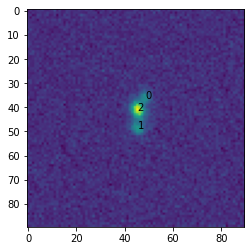

In [60]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

In [61]:
detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i]])

print(detected_positions)
deb = Deblend(blend['blend_images'][0]/80000, detected_positions, num_components=len(blend['blend_list'][0]), use_likelihood=True)


[[48.50189159298991, 36.42769893030225], [45.449543477093634, 48.80613481939498], [45.358632321590264, 41.2726271781927]]

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe542b8e210> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fe54a8f43d0>).
(90, 90, 6)
Some galaxies are too close from the border of the field to be considered here.


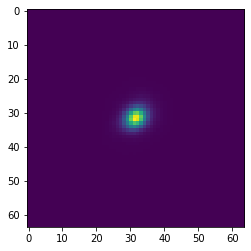

In [62]:
plt.imshow(deb.components[0][:, :, 2])

0
1
2


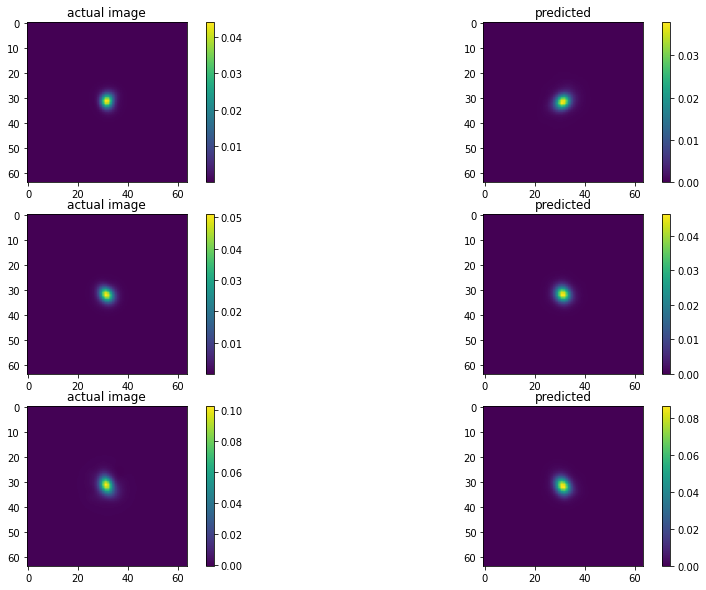

In [63]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(15,10*len(blend['blend_list'])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    print(i)
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 12.8))
    fig.colorbar(im1, ax=ax[i, 0])
    ax[i, 0].set_title("actual image")

    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    fig.colorbar(im2, ax=ax[i, 1])
    ax[i, 1].set_title("predicted")
    
plt.show()

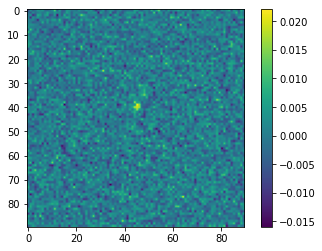

In [64]:
fig = plt.figure()
ax = fig.gca()
residual = deb.compute_residual()
im1 = ax.imshow(residual[:, :, 2])
fig.colorbar(im1, ax=ax)
